In [1]:
import pathlib
import requests

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster, decomposition, ensemble, linear_model
from sklearn import metrics, model_selection, pipeline, preprocessing, utils

# MNIST Dataset

The original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of 70000 28x28 black and white images in 10 classes. There are 60000 training images and 10000 test images.

In [2]:
# might be different if using Colab or Kaggle
PROJECT_ROOT_DIR = pathlib.Path(".")

DATA_DIR = PROJECT_ROOT_DIR / "data" / "mnist"
DATA_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = PROJECT_ROOT_DIR / "results" / "mnist"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

CV_FOLDS = 5

### Download and extract the data (if using Colab or Kaggle!)

In [3]:
URL = "https://github.com/KAUST-Academy/practical-tools-for-machine-learning/blob/october-2022/data/mnist/mnist.parquet?raw=true"

with open(DATA_DIR / "mnist.parquet", 'wb') as f:
    response = requests.get(URL)
    f.write(response.content)


### Load the data

We will load the data using the [Pandas](https://pandas.pydata.org/) library. Highly recommend the most recent edition of [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781491957653/) by Pandas creator Wes Mckinney for anyone interested in learning how to use Pandas.

In [4]:
data = pd.read_parquet(DATA_DIR / "mnist.parquet")
features = data.drop("label", axis=1)
target = data.loc[:, "label"]

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 52.3 MB


In [6]:
target.head()

0    5
1    0
2    4
3    1
4    9
Name: label, dtype: uint8

# Creating a Test Dataset

Before we look at the data any further, we need to create a test set, put it aside, and never look at it (until we are ready to test our trainined machine learning model!). Why? We don't want our machine learning model to memorize our dataset (this is called overfitting). Instead we want a model that will generalize well (i.e., make good predictions) for inputs that it didn't see during training. To do this we hold split our dataset into training and testing datasets. The training dataset will be used to train our machine learning model(s) and the testing dataset will be used to make a final evaluation of our machine learning model(s).


In [ ]:
model_selection.train_test_split?

In [7]:
SEED = 42
SEED_GENERATOR = np.random.RandomState(SEED)


def generate_seed():
    return SEED_GENERATOR.randint(np.iinfo("uint16").max)

In [8]:
# split the dataset into training and testing data
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)

train_features, test_features, train_target, test_target = model_selection.train_test_split(
    features,
    target,
    test_size=1e-1,
    random_state=_random_state
)

In [9]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 24297 to 27483
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 47.6 MB


In [10]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 64951 to 57273
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 5.3 MB


Again, if you want to you can write out the train and test sets to disk to avoid having to recreate them later.

In [11]:
_ = (train_features.join(train_target)
                   .to_parquet(DATA_DIR / "train.parquet", index=False))

_ = (test_features.join(test_target)
                   .to_parquet(DATA_DIR / "test.parquet", index=False))

## Feature Engineering

Feature engineering is one of the most important parts of any machine learning project. There are two main tasks in feature engineering.

* Feature selection: selecting the best subset of features for training. 
* Feature extraction: combining existing features to produce new features for training.
* Feature creation: finding additional data sources to use as features.

Feature engineering is often the most labor intensive part of building a machine learning pipeline and often requires extensive expertise/domain knowledge relevant to the problem at hand. Recently packages such as [featuretools](https://www.featuretools.com/) have been developed to (partially) automate the process of feature engineering.

### Feature Selection

In [12]:
(train_features.std(axis=0)
               .describe())

count    784.000000
mean      49.254254
std       44.177623
min        0.000000
25%        4.715801
50%       36.780250
75%      100.788743
max      113.899455
dtype: float64

In [13]:
minimum_threshold = 0 # maybe something greater than 0?
useful_train_pixels = train_features.std(axis=0) > minimum_threshold
useful_train_features = train_features.loc[:, useful_train_pixels]

In [13]:
useful_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 24297 to 27483
Columns: 716 entries, pixel13 to pixel780
dtypes: uint8(716)
memory usage: 43.5 MB


### Feature extraction using Principal Component Analysis (PCA)

In [ ]:
decomposition.PCA?

In [19]:
_seed = generate_seed()

# hyper-parameters
_pca_hyperparameters = {
    "n_components": 0.95,
    "whiten": False,
}

feature_extractor = decomposition.PCA(**_pca_hyperparameters)
extracted_train_features = feature_extractor.fit_transform(useful_train_features)

In [20]:
extracted_train_features.shape

(63000, 154)

In [21]:
extracted_train_features.mean(axis=0)

array([ 3.19333695e-14, -1.03076066e-14,  7.85341457e-15,  1.50860629e-14,
       -2.95080503e-14, -6.35202649e-16, -1.72659629e-14,  7.70905033e-15,
       -9.29705695e-15, -4.85063841e-15, -8.66185430e-15, -6.52526357e-15,
       -3.00277616e-15,  9.90338675e-15,  1.22853967e-14,  7.68017748e-15,
       -2.99555795e-15, -6.20766225e-15, -6.81399205e-15,  1.56635199e-14,
        1.73237086e-16,  1.99222649e-15,  7.94003311e-15,  4.07107152e-15,
        1.05385894e-15, -1.00766238e-14,  1.03653523e-14,  1.14913934e-14,
        4.09994437e-15,  9.36923907e-15,  4.21543576e-15,  2.59855629e-16,
       -6.23653510e-15, -7.18933907e-15,  4.44641854e-15, -4.30205430e-15,
       -1.12604106e-15, -5.16823973e-15, -3.32037748e-15,  1.52304271e-14,
        5.48584106e-16,  7.18933907e-15,  1.73237086e-16, -3.06052185e-15,
       -1.07406993e-14, -1.61687947e-15, -8.67629073e-15, -1.62121040e-14,
        2.52637417e-16, -6.33759006e-15,  9.75902251e-15,  7.82454172e-15,
       -1.09428093e-14, -

In [22]:
extracted_train_features.std(axis=0)

array([577.27750191, 496.29375844, 459.08500137, 430.87728834,
       409.03293985, 383.74116777, 335.34286161, 314.88331676,
       307.78138579, 283.77059483, 268.66441764, 264.65595496,
       242.05395066, 241.1432988 , 233.11228492, 226.15226312,
       212.65887617, 209.48116582, 201.83976482, 198.82730818,
       191.34932587, 186.08997111, 181.57346555, 176.62856369,
       173.983024  , 169.86875736, 166.57834143, 164.06322122,
       159.40587404, 153.82856211, 150.18389604, 148.69291515,
       143.65986804, 141.51342355, 139.48383776, 136.51331125,
       131.70275487, 129.3432964 , 128.17027647, 126.57441441,
       124.76169319, 123.45990291, 119.72186704, 116.57819813,
       114.79873939, 113.67287283, 111.254219  , 109.4034604 ,
       107.89770638, 104.57065802, 104.21013213, 103.0791844 ,
       100.84892321,  99.25521517,  98.38365094,  96.20531439,
        95.99817201,  94.03519684,  93.34653559,  91.57687084,
        90.75862768,  90.44494885,  88.72683478,  87.07

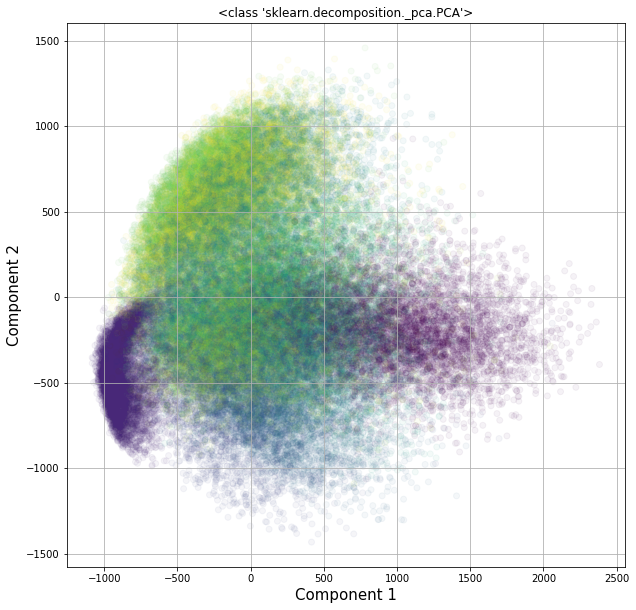

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_ = ax.scatter(
    extracted_train_features[:, 0],
    extracted_train_features[:, 1],
    c=train_target,
    alpha=0.05
)
_ = ax.set_xlabel("Component 1", fontsize=15)
_ = ax.set_ylabel("Component 2", fontsize=15)
_ = ax.set_title(type(feature_extractor))
_ = ax.grid(True)

### Exercise: To whiten, or not to whiten?

Take a close look at the doc string for the `decomposition.PCA` algorithm. What happens if you set `n_components` to a number between 0 and 1 (i.e., `n_components=0.95`)? Why might you want to do this? What does setting `whiten=True` do to the output of the algorithm? Re-run the PCA algorithm above setting `whiten=True` to confirm your answer. Why might you want to set `whiten=True`? 

In [24]:
_seed = generate_seed()

# hyper-parameters
_pca_hyperparameters = {
    "n_components": 0.95,
    "whiten": True,
}

feature_extractor = decomposition.PCA(**_pca_hyperparameters)
extracted_train_features = feature_extractor.fit_transform(useful_train_features)

In [25]:
extracted_train_features.std(axis=0)

array([0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999

### Feature extraction using K-Means

In [26]:
_seed = generate_seed()

_extractor_hyperparameters = {
    "n_clusters": 10,
    "random_state": np.random.RandomState(_seed),
}

feature_extractor = cluster.KMeans(**_extractor_hyperparameters)

In [27]:
extracted_train_features = feature_extractor.fit_transform(useful_train_features)

In [28]:
extracted_train_features[:5, :]

array([[2361.68202177, 2562.14238917, 1817.13628379, 2163.93114448,
        1922.50048419, 2401.42874576, 2058.50549766, 2484.97163696,
        2329.84350757, 2492.94850173],
       [1902.84922761, 2200.33030842, 1765.71978515, 2043.37312923,
        1626.95383154, 1969.40600237, 1846.74978913, 2487.04457822,
        1069.85099731, 1805.66059537],
       [1864.39952014, 1831.08150527, 1634.36902087, 2121.99216269,
        2008.62352973, 1949.34129189, 1777.01830349, 2380.63708793,
        1869.02531176, 1252.85571528],
       [2274.719953  , 2003.44664962, 2066.6102117 , 2285.30029802,
        2345.14511867, 2337.2704397 , 1639.09782868, 2500.41904999,
        2187.45080863, 1558.47653105],
       [1731.24496486, 1561.68455041, 1936.21907672, 2123.34338223,
        1965.53506114, 1918.05242845, 1927.06244609, 2386.12353313,
        1975.31160286, 1680.47333518]])

In [29]:
extracted_train_features.shape

(63000, 10)

# Select, train, and validate some pipelines

### Perceptron

In [30]:
linear_model.Perceptron?

In [30]:
_seed = generate_seed()

_extractor_hyperparameters = {
    "n_clusters": 10,
    "random_state": np.random.RandomState(_seed),
}

_seed = generate_seed()

_classifier_hyperparameters = {
    "loss": "perceptron",
    "n_jobs": -1,
    "random_state": np.random.RandomState(_seed),
}

ml_pipeline = pipeline.make_pipeline(
    cluster.KMeans(**_extractor_hyperparameters),
    preprocessing.MinMaxScaler(),
    linear_model.SGDClassifier(**_classifier_hyperparameters)
)

In [31]:
_ = ml_pipeline.fit(useful_train_features, train_target)

After training the pipeline we can assess its performance on the training data...

In [32]:
# make predictions
_train_predictions = ml_pipeline.predict(useful_train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6192
           1       0.88      0.96      0.92      7083
           2       0.68      0.89      0.77      6264
           3       0.94      0.20      0.33      6408
           4       0.54      0.71      0.61      6213
           5       0.57      0.24      0.34      5696
           6       0.95      0.76      0.85      6163
           7       0.84      0.71      0.77      6579
           8       0.50      0.70      0.59      6121
           9       0.37      0.57      0.45      6281

    accuracy                           0.67     63000
   macro avg       0.71      0.66      0.65     63000
weighted avg       0.72      0.67      0.66     63000



In [34]:
metrics.confusion_matrix?

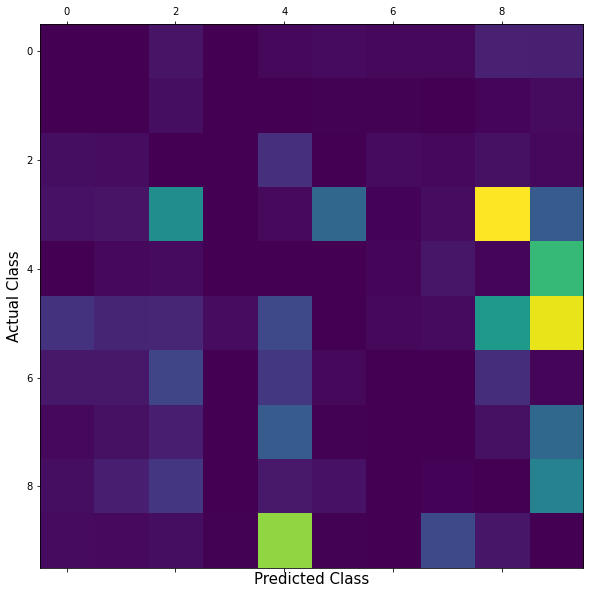

In [37]:
confusion_matrix = metrics.confusion_matrix(
    train_target,
    _train_predictions,
    normalize="true",
)

# visualize the normalized confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
np.fill_diagonal(confusion_matrix, 0)
_ = ax.matshow(confusion_matrix)
_ = ax.set_xlabel("Predicted Class", fontsize=15)
_ = ax.set_ylabel("Actual Class", fontsize=15)
plt.show()

...and then assess its performance on new data using cross validation.

In [38]:
CV_FOLDS = 5

_train_predictions = model_selection.cross_val_predict(
    ml_pipeline,
    X=extracted_train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# report the accuracy on the cv data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


              precision    recall  f1-score   support

           0       0.80      0.79      0.79      6192
           1       0.93      0.85      0.89      7083
           2       0.46      0.58      0.52      6264
           3       0.55      0.38      0.45      6408
           4       0.39      0.52      0.45      6213
           5       0.27      0.48      0.35      5696
           6       0.59      0.64      0.61      6163
           7       0.64      0.24      0.35      6579
           8       0.45      0.13      0.20      6121
           9       0.38      0.54      0.45      6281

    accuracy                           0.52     63000
   macro avg       0.55      0.52      0.51     63000
weighted avg       0.56      0.52      0.51     63000



You can also use SGD to fit perceptrons as well!

In [ ]:
linear_model.SGDClassifier?

In [39]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "loss": "perceptron",
    "fit_intercept": True,
    "verbose": 0,
    "random_state": np.random.RandomState(_seed),
}

ml_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    linear_model.SGDClassifier(**_classifier_hyperparameters)
)

In [40]:
_ = ml_pipeline.fit(useful_train_features, train_target)

In [42]:
# make predictions
_train_predictions = ml_pipeline.predict(useful_train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6192
           1       0.98      0.96      0.97      7083
           2       0.93      0.83      0.88      6264
           3       0.69      0.95      0.80      6408
           4       0.86      0.96      0.91      6213
           5       0.89      0.81      0.85      5696
           6       0.95      0.95      0.95      6163
           7       0.95      0.86      0.90      6579
           8       0.86      0.82      0.84      6121
           9       0.88      0.79      0.83      6281

    accuracy                           0.89     63000
   macro avg       0.90      0.89      0.89     63000
weighted avg       0.90      0.89      0.89     63000



In [43]:
_train_predictions = model_selection.cross_val_predict(
    ml_pipeline,
    X=useful_train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# report the accuracy on the cv data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.7s finished


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6192
           1       0.95      0.97      0.96      7083
           2       0.86      0.89      0.88      6264
           3       0.90      0.83      0.86      6408
           4       0.89      0.91      0.90      6213
           5       0.78      0.87      0.82      5696
           6       0.94      0.93      0.93      6163
           7       0.87      0.91      0.89      6579
           8       0.84      0.81      0.83      6121
           9       0.87      0.78      0.82      6281

    accuracy                           0.89     63000
   macro avg       0.89      0.89      0.88     63000
weighted avg       0.89      0.89      0.89     63000



### Exercise: Early Stopping

Read through the documentation for the `linear_model.SGDClassifier` and implement a Perceptron and train the model using early stopping to control overfitting.

In [44]:
linear_model.SGDClassifier?

In [45]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "loss": "perceptron",
    "fit_intercept": True,
    "verbose": 1,
    "early_stopping": True,
    "validation_fraction": 0.2,
    "random_state": np.random.RandomState(_seed),
}

ml_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    linear_model.SGDClassifier(**_classifier_hyperparameters)
)

_ = ml_pipeline.fit(useful_train_features, train_target)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 35.89, NNZs: 577, Bias: -54.798074, T: 50400, Avg. loss: 0.516670
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 25.81, NNZs: 595, Bias: -42.253485, T: 100800, Avg. loss: 0.106732
Total training time: 0.21 seconds.
-- Epoch 3
Norm: 21.37, NNZs: 596, Bias: -34.634386, T: 151200, Avg. loss: 0.073193
Total training time: 0.34 seconds.
-- Epoch 4
Norm: 18.72, NNZs: 598, Bias: -29.128757, T: 201600, Avg. loss: 0.058210
Total training time: 0.48 seconds.
-- Epoch 5
Norm: 16.52, NNZs: 599, Bias: -25.101613, T: 252000, Avg. loss: 0.047813
Total training time: 0.60 seconds.
-- Epoch 6
Norm: 15.07, NNZs: 603, Bias: -21.837059, T: 302400, Avg. loss: 0.041094
Total training time: 0.74 seconds.
Convergence after 6 epochs took 0.80 seconds
-- Epoch 1
Norm: 21.86, NNZs: 576, Bias: -9.499640, T: 50400, Avg. loss: 0.280851
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 14.01, NNZs: 587, Bias: -4.754350, T: 100800, Avg. loss: 0.043887
Total training time: 0.21 seconds.
-- Epoc

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.8s finished


### Exercise: Feature engineering and Gradient Boosted Trees

Combine feature selection, feature engineering usin PCA with Gradient Boosted Trees. How does this compare in terms of computation speed, and accuracy to other methods?

In [51]:
_seed = generate_seed()

_pca_hyperparameters = {
    "n_components": 0.95,
    "random_state": np.random.RandomState(_seed)
}

_seed = generate_seed()

_classifier_hyperparameters = {
    "random_state": np.random.RandomState(_seed),
    "verbose": 1,
    "early_stopping": True,
    "validation_fraction": 0.2
}

ml_pipeline = pipeline.make_pipeline(
    decomposition.PCA(**_pca_hyperparameters),
    ensemble.HistGradientBoostingClassifier(**_classifier_hyperparameters)
)

_ = ml_pipeline.fit(useful_train_features, train_target)

Binning 0.062 GB of training data: 1.686 s
Binning 0.016 GB of validation data: 0.109 s
Fitting gradient boosted rounds:
[1/100] 10 trees, 310 leaves (31 on avg), max depth = 9, train loss: 1.69188, val loss: 1.70500, in 0.539s
[2/100] 10 trees, 310 leaves (31 on avg), max depth = 13, train loss: 1.39648, val loss: 1.41740, in 0.601s
[3/100] 10 trees, 310 leaves (31 on avg), max depth = 11, train loss: 1.19070, val loss: 1.21734, in 0.893s
[4/100] 10 trees, 310 leaves (31 on avg), max depth = 10, train loss: 1.03477, val loss: 1.06526, in 0.724s
[5/100] 10 trees, 310 leaves (31 on avg), max depth = 11, train loss: 0.91148, val loss: 0.94580, in 0.641s
[6/100] 10 trees, 310 leaves (31 on avg), max depth = 11, train loss: 0.81025, val loss: 0.84729, in 0.618s
[7/100] 10 trees, 310 leaves (31 on avg), max depth = 10, train loss: 0.72703, val loss: 0.76582, in 0.604s
[8/100] 10 trees, 310 leaves (31 on avg), max depth = 10, train loss: 0.65581, val loss: 0.69753, in 0.612s
[9/100] 10 trees

# Evaluate your models on the test dataset

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. Remember to re-train your model on the full training data prior to evaluating on the test data.

In [ ]:
estimators = [
    ???
]

for estimator in estimators:
    _ = estimator.fit(train_features, train_target)

In [ ]:
for estimator in estimators:

    # make predictions
    _test_predictions = estimator.predict(test_features)

    # generate a classification report
    _report = metrics.classification_report(
        test_target,
        _test_predictions,
    )
    print(estimator)
    print(_report)


If you did a lot of tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on new, unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.